## Yelper -  A recommendation system to accelerate business growth

The idea behind  "Yelper" is to create an automated system that provides feedback to the business owners on how to improve their businesses. There are many business owners who set up businesses and open them to the public and also receive reviews that provide insight into what their diners liked in their restaurant and what they did not. Some times restaurants take these into consideration and try and improve on specific dishes or perhaps maybe train their staff members to tend to customers better. Sometimes there is an overwhelming amount of reviews, and there is no clear course of action for the owners to pursue that would ensure an improvement in their business. Also it is clearly more rewarding to make an informed decision, given all the information. It is vital that the owners understand how their restaurant compares to the others in the same category. What are their strengths and weaknesses with respect to the others. All this information can be obtained from the rich source of information available in the form of reviews. 

We intend to develop an automated recommender system that provides suggestions to business owners based on the information obtained from yelp reviews. Our hope is that these suggestions will provide them with some actionable feedback to accelerate the growth of their businesses. These suggestions will be based on reviews and ratings each restaurant has received when compared to other competing restaurants in their respective categories. Restaurants are categorized by the kind of food they serve and this information is available from the Yelp API. We begin by first extracting reviews from every restaurant as well as other ancillary information. We perform sentiment analysis on the reviews for each restaurant and then make suggestions based on the key topics that come up based on topic modelling of all restaurants in a given category.

## Installation of necessary libraries

For this project we need the following Libraries:
1) Beautiful Soup
2) numpy 
3) pandas
4) nltk
5) gensim
6) textblob

We have used most of the above libraries in the duration of the course and assume that these libraries are already installed on the users computer. We use the **gensim** and **textblob** library that has not been introduced in the course and can be installed as follows :

*conda install -c anaconda gensim=0.13.3*

*pip install -U textblob*
*python -m textblob.download_corpora*


The nltk library is a useful library for any natual language processing task including but not limited to pos tagging, detection stop words,tokenization and lemmatization. We use this library to perform the aforementioned tasks in our project. We also use gensim library[1], which is used frequently for topic modelling. In our project we hope to obtain the most relevant topics from the reviews of each category of restaurant via topic modelling and provide each restaurant with suggestions for improvement based on  the topics derived from the model.

We use textblob library[2] to perform sentiment analysis on the reviews.

## Imports

In [255]:
# setup library imports
import io, time, json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
import string
from collections import Counter
from gensim import corpora, models
from nltk.tokenize import word_tokenize
import gensim
from textblob import TextBlob

# import yelp client library
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

### Set up plot parameters

In [4]:
import matplotlib
# Use svg backend for better quality
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0) 
plt.style.use('ggplot')

### Client authentication and API Query

In [6]:
# To authenticate the api calls
def authenticate(config_filepath):
    """
    Create an authenticated yelp-python client.

    Args:
        config_filepath (string): relative path (from this file) to a file with your Yelp credentials

    Returns:
        client (yelp.client.Client): authenticated instance of a yelp.Client
    """
    with io.open(config_filepath) as cred:
        creds = json.load(cred)
        auth = Oauth1Authenticator(**creds)
        client = Client(auth)
    return client

In [7]:
# To get business object corresponding to the search query
def yelp_search(client, query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of yelp.obj.business.Business objects
    """
    
    # Write solution here
    response = client.search(query)
    return response.total , response.businesses

In [8]:
y_client = authenticate('yelp_api_keys.json')

In [9]:
def all_restaurants(client, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of yelp.obj.business.Business objects
    """
    query_output = 20
    offset = 0
    businesses = []
    while(query_output!=0):
        params = {
        "category_filter" : "restaurants",
        "offset" : offset
        }
        if offset == 980:
            break
        response = client.search(query,**params)
        businesses.extend(response.businesses)
        offset += 20 
        query_output = len(response.businesses)
        time.sleep(0.3)
    return businesses

### Obtaining Data from the Yelp API

 We use Yelp to retrieve restaurant relevant data(reviews, ratings, location etc)from the API for different locations in Pittsburgh. We specifically limit the analysis to the Oakland, Shadyside and Squirrel Hill locations as shown below.


In [24]:
oakland_data = all_restaurants(y_client, 'Oakland, Pittsburgh')

In [25]:
Shadyside_data = all_restaurants(y_client, 'Shadyside, Pittsburgh')

In [26]:
Squirrel_hill_data = all_restaurants(y_client, 'Squirrel Hill, Pittsburgh')

Concatenate the data obtained from all three locations into one single data frame and use it to build a dictionary containing keys that pertain to the relevant subset of the restaurant data required for our analysis. We make sure to include the keys/fields such as the name of the restaurant, its location, number of reviews and ratings it has received and which broad categories of restaurants it falls under.

In [27]:
total_data = oakland_data + Shadyside_data + Squirrel_hill_data

In [28]:
res_dict = {'Res_id' : [i.id for i in total_data] ,
              'Name' : [i.name for i in total_data],
      'Neighbourhood': ['Oakland']*len(oakland_data) + ['Shadyside']*len(Shadyside_data) + ['Squirrel Hill']*len(Squirrel_hill_data) ,
               'Url' : [i.url for i in total_data],
      'Review_count' : [i.review_count for i in total_data],
             'Rating': [i.rating for i in total_data],
         'Categories': [[j.name for j in i] for i in [k.categories for k in total_data]]}

In [29]:
total_df = pd.DataFrame(res_dict)

In [30]:
total_df = total_df[['Res_id', 'Name','Neighbourhood', 'Url', 'Categories','Review_count','Rating']]

Here is a glimpse into our data set ! 

In [31]:
total_df.head()

,Res_id,Name,Neighbourhood,Url,Categories,Review_count,Rating
0,conflict-kitchen-pittsburgh,Conflict Kitchen,Oakland,https://www.yelp.com/biz/conflict-kitchen-pitt...,[Restaurants],148,4.5
1,legume-pittsburgh,Legume,Oakland,https://www.yelp.com/biz/legume-pittsburgh?adj...,"[French, American (Traditional), Soul Food]",298,4.5
2,butterjoint-pittsburgh-3,Butterjoint,Oakland,https://www.yelp.com/biz/butterjoint-pittsburg...,"[American (New), Bars]",139,4.0
3,oishii-bento-pittsburgh,Oishii Bento,Oakland,https://www.yelp.com/biz/oishii-bento-pittsbur...,"[Japanese, Korean, Sushi Bars]",196,4.0
4,sichuan-gourmet-pittsburgh-7,Sichuan Gourmet,Oakland,https://www.yelp.com/biz/sichuan-gourmet-pitts...,[Szechuan],73,4.0


In [32]:
len(total_df)

2480

## Exploratory Data Analysis

Before digging into the data, lets see if there are any duplicates. 

In [33]:
total_df['Res_id'].value_counts().head()

mcdonalds-pittsburgh-17                      4
little-tokyo-bistro-pittsburgh               4
applewood-smoke-burger-company-pittsburgh    4
vocelli-pizza-pittsburgh-5                   4
shiraz-kabob-and-hookah-pittsburgh           4
Name: Res_id, dtype: int64

In [34]:
# Removing the duplicates, assuming that the restaurant falls in the first location 
total_df.drop_duplicates(subset = 'Res_id', keep = 'first', inplace = True)

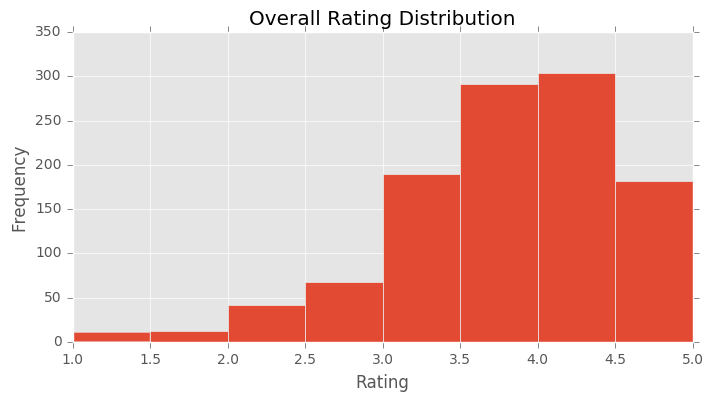

In [37]:
# overall Rating Distribution 
total_df['Rating'].plot.hist(bins = 8)
plt.title('Overall Rating Distribution')
plt.ylabel("Frequency")
plt.xlabel("Rating")

From the plot above, we get a sense of the range of ratings for restaurants in the three specific locations. Most restaurants seem to fall into the category with 4-4.5 stars.

###  Distribution of the number of reviews

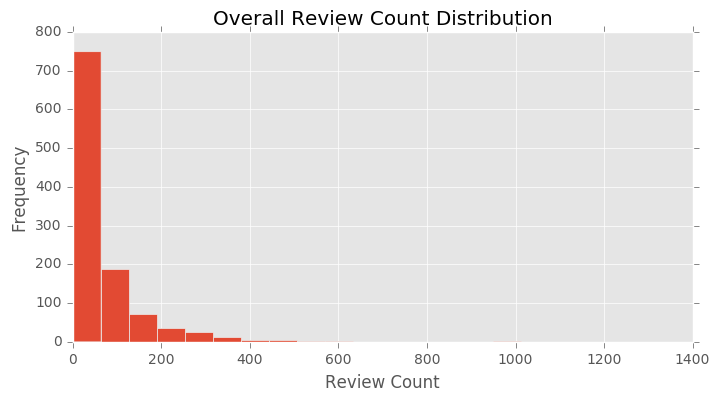

In [38]:
# Overall Distribution of review count
total_df['Review_count'].plot.hist(bins = 20)
plt.title('Overall Review Count Distribution')
plt.ylabel("Frequency")
plt.xlabel("Review Count")

In [39]:
total_df[['cat1','cat2','cat3']] = total_df['Categories'].apply(lambda x : pd.Series(x))

In [40]:
total_df.head()

,Res_id,Name,Neighbourhood,Url,Categories,Review_count,Rating,cat1,cat2,cat3
0,conflict-kitchen-pittsburgh,Conflict Kitchen,Oakland,https://www.yelp.com/biz/conflict-kitchen-pitt...,[Restaurants],148,4.5,Restaurants,NaN,NaN
1,legume-pittsburgh,Legume,Oakland,https://www.yelp.com/biz/legume-pittsburgh?adj...,"[French, American (Traditional), Soul Food]",298,4.5,French,American (Traditional),Soul Food
2,butterjoint-pittsburgh-3,Butterjoint,Oakland,https://www.yelp.com/biz/butterjoint-pittsburg...,"[American (New), Bars]",139,4.0,American (New),Bars,NaN
3,oishii-bento-pittsburgh,Oishii Bento,Oakland,https://www.yelp.com/biz/oishii-bento-pittsbur...,"[Japanese, Korean, Sushi Bars]",196,4.0,Japanese,Korean,Sushi Bars
4,sichuan-gourmet-pittsburgh-7,Sichuan Gourmet,Oakland,https://www.yelp.com/biz/sichuan-gourmet-pitts...,[Szechuan],73,4.0,Szechuan,NaN,NaN


In [41]:
melted_total = pd.melt(total_df, id_vars = ['Res_id','Name', 'Neighbourhood','Url','Review_count', 'Rating'], 
                        value_vars = ['cat1','cat2','cat3'], value_name = 'Categories').drop('variable',axis = 1)

In [42]:
melted_total.head()

,Res_id,Name,Neighbourhood,Url,Review_count,Rating,Categories
0,conflict-kitchen-pittsburgh,Conflict Kitchen,Oakland,https://www.yelp.com/biz/conflict-kitchen-pitt...,148,4.5,Restaurants
1,legume-pittsburgh,Legume,Oakland,https://www.yelp.com/biz/legume-pittsburgh?adj...,298,4.5,French
2,butterjoint-pittsburgh-3,Butterjoint,Oakland,https://www.yelp.com/biz/butterjoint-pittsburg...,139,4.0,American (New)
3,oishii-bento-pittsburgh,Oishii Bento,Oakland,https://www.yelp.com/biz/oishii-bento-pittsbur...,196,4.0,Japanese
4,sichuan-gourmet-pittsburgh-7,Sichuan Gourmet,Oakland,https://www.yelp.com/biz/sichuan-gourmet-pitts...,73,4.0,Szechuan


In [43]:
melted_total = melted_total.dropna(subset=['Categories'])

In [44]:
top10_categories = melted_total['Categories'].value_counts()[:10]

The top 10 categories of restaurant types are as shown below :

In [45]:
top10_categories

Pizza                     164
Sandwiches                162
American (Traditional)    125
American (New)            114
Italian                    88
Fast Food                  78
Bars                       72
Breakfast & Brunch         63
Burgers                    63
Chinese                    55
Name: Categories, dtype: int64

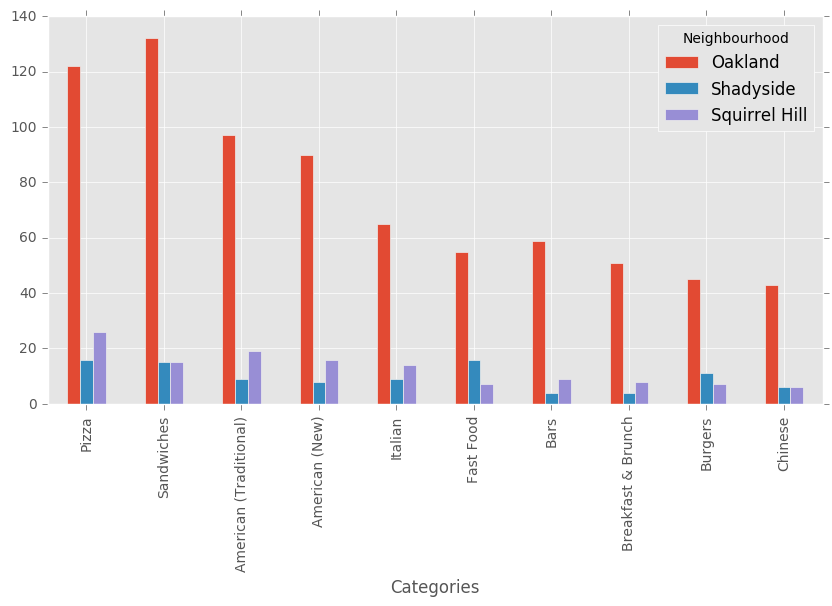

In [47]:
# Top 10 Restaurant Categories grouped by Neighbourhood 
melted_total.groupby('Categories')['Neighbourhood'].value_counts().ix[top10_categories.index].unstack().plot.bar(legend=True,figsize=(10, 5))

The above plot provides some insight of the number of restaurants per location, but limited to the top 10 categories of restaurants. It is evident that squirrel hill houses the majority of the number of restaurants with exception of the fast food category. Of the three locations, the number of restaurants in shadyside are smaller in number when compared to the other two locations.

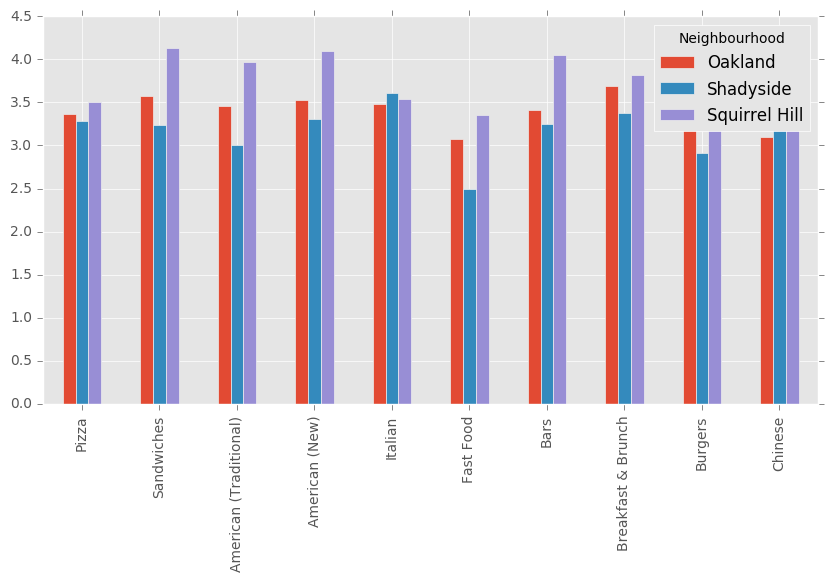

In [48]:
# Ratings distribution across top 10 categories grouped by neighbourhood
melted_total.groupby(['Categories','Neighbourhood']).mean().unstack()['Rating'].ix[top10_categories.index].plot.bar(legend=True,figsize=(10, 5))

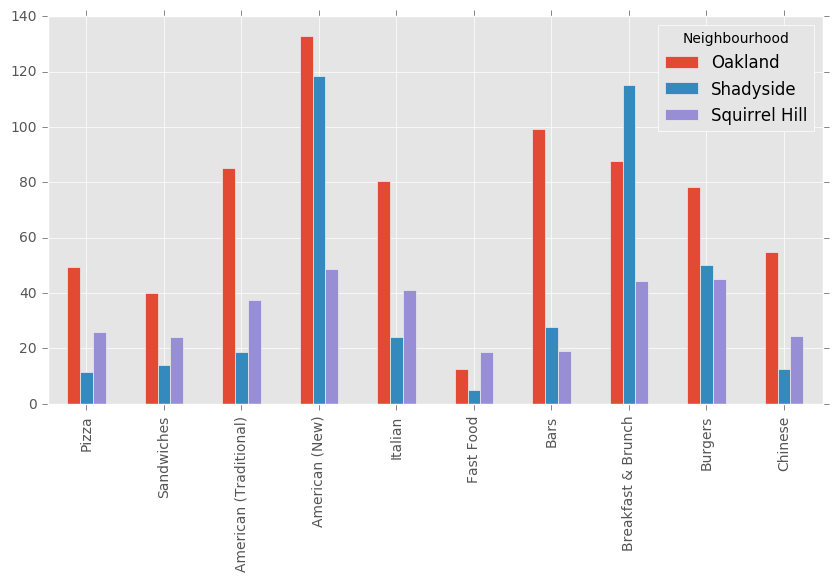

In [51]:
# Review_count distribution across categories
melted_total.groupby(['Categories','Neighbourhood']).mean().unstack()['Review_count'].ix[top10_categories.index].plot.bar(legend=True,figsize=(10, 5))

##  Parse reviews of a restaurant

In [58]:
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        status_code (integer):
        raw_html (string): the raw HTML content of the response, properly encoded according to the HTTP headers.
    """

    r = requests.get(url)
    return (r.status_code,r.text)

In [11]:
def parse_page(html):
    """
    Parse the reviews on a single page of a restaurant.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    
    soup = BeautifulSoup(html, 'html.parser')
    reviews_list = []
    reviews = soup.find_all(itemprop="review")
    for review in reviews:
        review_dict= {
            #'review_id': review['data-review-id'],
            #'user_id': review['data-signup-object'].split("user_id:")[1],
            'rating': float(review.find(itemprop="ratingValue")['content']),
            'date': review.find(itemprop="datePublished")['content'],
            'text': review.find(itemprop="description").get_text().strip()
        }
        reviews_list.append(review_dict)

    url = soup.find(rel="next")
    url = None if url is None else url['href']

    parsed_object = (reviews_list,url)
    return parsed_object

##  Extract reviews of a restaurant

We first define a function to extract reviews for a single restaurant as shown below.

In [12]:
def extract_reviews(url):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """
    reviews_list = []
    while (url is not None):
        yelp_page = retrieve_html(url)
        reviews, url = parse_page(yelp_page[1])
        reviews_list.extend(reviews)
        time.sleep(0.05)
    return reviews_list

In [56]:
def extract_reviews_categories(df, categories_list):
    """
    Retrieves reviews for all the restaurants in the given categories list. 
    Parameters : 
        df(dataframe) : containing reviews for all the restaurants
        categories_list (list) : list of required categories
    
    Returns (dataframe): consisting of reviews of restaurants belonging to the above categories
    """
    restaurants_filtered = list(set([(row['Res_id'], row['Url']) 
                                     for ind,row in df.iterrows() if row['Categories'] in categories_list]))
    
    # Extracting reviews for each restaurant and storing them in a dictionary
    reviews = { rest[0] : extract_reviews(rest[1]) for rest in restaurants_filtered}
    
    # Creating a dataframe containing the reviews for all the above restaurants
    rest_id = []
    reviews_text = []
    dates = []
    ratings = []
    for key,val in reviews.iteritems():
        rest_id += [key]*len(val)
        reviews_text += [ i['text'] for i in val]
        dates += [i['date'] for i in val]
        ratings += [i['rating'] for i in val]
    temp = { "rest_id" : rest_id, "reviews_text" : reviews_text , "dates" : dates , "ratings" : ratings }
    output_df = pd.DataFrame(data = temp)
    return output_df    

### Extract reviews of restaurant for the top three categories

We now obtain the data(reviews) per category of restaurants to train a Latent Dirchlet Allocation(LDA) Model in order to obtain the predominant topics in a given category of restaurants as shown below.

In [57]:
# Extracting all restaurant reviews for top 3 categories
cat_pizza = extract_reviews_categories(melted_total, ['Pizza'])
cat_Sandwich = extract_reviews_categories(melted_total, ['Sandwiches'])
cat_American = extract_reviews_categories(melted_total, ['American (Traditional)'])

In [ ]:
#Saving all the reviews in csv files so as to not run it everytime  
#cat_pizza.to_csv('pizza.csv',index=False , encoding='utf-8')
#cat_Sandwich.to_csv('sandwich.csv',index=False , encoding='utf-8')
#cat_American.to_csv('american.csv',index=False , encoding='utf-8')

In [191]:
# get data from csv files for top 3 restaurant categories
#cat_pizza = pd.read_csv('pizza.csv', encoding = 'utf-8')
#cat_sandwich = pd.read_csv('sandwich.csv', encoding = 'utf-8')
#cat_american = pd.read_csv('american.csv', encoding = 'utf-8')

In [64]:
# number of reviews 
print len(cat_pizza) , len(cat_sandwich) , len(cat_american)

6850 5872 9128


In [192]:
cat_pizza.head(2)

,dates,ratings,rest_id,reviews_text
0,2016-08-03,5.0,paisanos-pittsburgh,Been eating here for over 15yrs. Reading peopl...
1,2016-09-09,1.0,paisanos-pittsburgh,Just moved to the area and really wanted to tr...


### Data Preprocessing

Before training model, we need to preprocess the data for any natural language processing application. Since we are looking at text in the form of reviews we need to clean up the data before using it our analysis. We carry out these three steps as a part of pre-processing :

1) Tokenization : Break the text down to words. <br /> 
2) Removal of Stop Words and Rare Words : Find and remove rare and stop words. <br />
3) Lemmatization : Reduced words to their word root. For example; reduce driven, driver, drive to drive.  <br />


In [67]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case, handles punctuation and removes Stop words 
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    # To remove any tags present in the review 
    soup = BeautifulSoup(text,'html.parser')
    text = soup.get_text()
    
    tspt = text.lower()
    tspt = tspt.replace("'s",'')
    tspt = tspt.replace("'",'')
    for ii in string.punctuation:
        tspt = tspt.replace(ii, ' ')
    tspt = nltk.word_tokenize(tspt) 
    
    # To remove the stop words 
    stopwords=nltk.corpus.stopwords.words('english')

    wrds = []
    for tt in tspt : 
        if tt not in stopwords:
            try :
                wrd = lemmatizer.lemmatize(tt)
            except :
                continue

            wrds.append( wrd)
    
    return wrds

In [69]:
def tokenize_review(df,field_name):
    """Tokenizes the review in the dataframe and creates it as a new column
    Inputs: 
        df(dataframe) : reviews dataframe
        fied_name(String) : field in the dataframe having the review
    Returns : 
        Dataframe with a new column consisting of tokenized reviews
    
    """
    lemm_text =  [process(row[field_name]) for ind, row in df.iterrows()]
    df = df.assign(reviews_token = lemm_text)
    return df 

In [193]:
cat_pizza = tokenize_review(cat_pizza,'reviews_text' )

In [71]:
cat_pizza.head(2)

,dates,ratings,rest_id,reviews_text,reviews_token
0,2016-08-03,5.0,paisanos-pittsburgh,Been eating here for over 15yrs. Reading peopl...,"[eating, 15yrs, reading, people, review, reali..."
1,2016-09-09,1.0,paisanos-pittsburgh,Just moved to the area and really wanted to tr...,"[moved, area, really, wanted, try, place, call..."


After performing tokenization and removing the stop words from the reviews we determine and remove rare words. Rare words are those words whose frequency is equal to 1. To elucidate, these words occur only once among all reviews for all restaurants in a given category. These words are removed from the reviews.

In [74]:
def get_rare_words(processed_reviews,field_name):
    """ use the word count information across all reviews to come up with a feature list
    Inputs:
        processed_reviews: pd.DataFrame
    Outputs:
        list(str): list of rare words, sorted alphabetically.
    """
    
    out = []
    for ii in processed_reviews.iterrows() :
        out = out + ii[1][field_name]
    
    outfi = []
    of = Counter(out)
    for kk in of.keys() :
        if of[kk] == 1:
            outfi.append(kk)

    outfi = sorted(outfi)
    
    return outfi


In [256]:
rare_wrds = get_rare_words(cat_pizza, 'reviews_token')

In [81]:
def remove_rare(text, rare_wrds):
    """Removes rare words from the review tokens
    Inputs:
        text(list): tokenized review
        rare_wrds (list): rare words  
    Outputs:
        list of words, without the rare words.
    """
    output = []
    for wrd in text:
        if wrd not in rare_wrds:
            output.append(wrd)
    return output

We finally obtain the reviews without the rare words.

In [82]:
def reviews_without_rare_words (df, token_field,  rare_words):
    """To get the tokenized review without the rare words
    Inputs: 
        df(dataframe): Reviews dataframe
        token_field (String) : field containing the tokenized reviews
        rare_words (list) : List of rarewords 
    Returns : 
        Dataframe with other column named 'reviews_without_rare_words' 
    """
    remove_rare_wrds = df[token_field].apply( lambda x: remove_rare(x, rare_wrds))
    df = df.assign(reviews_without_rare_words = remove_rare_wrds)
    return df 

In [195]:
cat_pizza = reviews_without_rare_words(cat_pizza,'reviews_token',rare_wrds)

In [84]:
cat_pizza.head(2)

,dates,ratings,rest_id,reviews_text,reviews_token,reviews_without_rare_words
0,2016-08-03,5.0,paisanos-pittsburgh,Been eating here for over 15yrs. Reading peopl...,"[eating, 15yrs, reading, people, review, reali...","[eating, reading, people, review, realized, or..."
1,2016-09-09,1.0,paisanos-pittsburgh,Just moved to the area and really wanted to tr...,"[moved, area, really, wanted, try, place, call...","[moved, area, really, wanted, try, place, call..."


### LDA Model

LDA is a generative statistical model that allows us to explain a set of observed features, which in our case is the document-term matrix in the form of unobserved groups or topics that capture the underlying similarity in the data[3]. The LDA model assumes that document or reviews in our case are created by topics and the words in the reviews are generated from the topics based on their probability distribution. Given the corpus of data which is the corpus of reviews for application the LDA model reverse engineers the process and determines the topics that are capable of generating these reviews(or documents).

In [133]:
def create_LDA_model(df, review_field, no_topics, no_passes):
    """creates LDA model 
    Inputs:
        df (dataframe) : Reviews dataframe
        review_field (String) : tokenized reviews column
        no_topics (integer) : number of topics for LDA model
        no_passes(integer) : number of passes for LDA model
    Returns :
            tuple (corpusm, gensim.models.ldamodel.LdaModel, Dictionary)  
    """
    text = list(df[review_field])
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(txt) for txt in text]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=no_topics, id2word = dictionary, passes=no_passes)
    return (corpus, ldamodel, dictionary)

We split the data into test and train data for each restaurant category in order to train our model. The reviews data is split into 90% train data and 10% test data.

In [116]:
np.random.seed(1)
def train_test_split(df, train_size):
    """Splits the dataframe to train and test according to the given size 
    Inputs: 
        df(dataframe) : Reviews dataframe
        train_size(float) : ratio of train size
    Returns: 
        tuple(train,test) dataframes
    """
    random_perm = np.random.permutation(len(df))
    train = df.iloc[random_perm[:train_size*len(df)]]
    test = df.iloc[random_perm[train_size*len(df):]]
    return (train,test)

In [140]:
pizza_train,pizza_test = train_test_split(cat_pizza,0.9)

We train our LDA model on the training data set of reviews for the "pizza category" of restaurants as shown below by using the *create_LDA_model* function created above.

In [134]:
pizza_corpus, pizza_train_model, pizza_dictionary = create_LDA_model(pizza_train, 'reviews_without_rare_words', 5, 10)

First We try to obtain the five predominant topics in the category of pizza restaurants. Notice that the number of topics that can be obtained can be varied by changing the values passed to the *'num_topics'* argument in the model, the same holds true to the number of words that are required to describe a certain topic, as a topic is defined as a distribution of words available in the corpus.

In [135]:
pizza_train_model.print_topics(num_topics = 5 ,num_words = 10)

[(0,
  u'0.024*"pizza" + 0.018*"place" + 0.018*"food" + 0.015*"good" + 0.013*"time" + 0.011*"delivery" + 0.010*"order" + 0.010*"service" + 0.010*"always" + 0.009*"great"'),
 (1,
  u'0.055*"pizza" + 0.015*"good" + 0.011*"great" + 0.011*"crust" + 0.010*"sauce" + 0.009*"cheese" + 0.009*"place" + 0.008*"salad" + 0.007*"fresh" + 0.007*"also"'),
 (2,
  u'0.013*"good" + 0.012*"place" + 0.012*"great" + 0.012*"burger" + 0.012*"beer" + 0.011*"food" + 0.009*"meatball" + 0.009*"bar" + 0.006*"really" + 0.006*"one"'),
 (3,
  u'0.013*"pizza" + 0.012*"order" + 0.010*"food" + 0.010*"ordered" + 0.009*"time" + 0.008*"would" + 0.008*"place" + 0.007*"like" + 0.007*"one" + 0.007*"minute"'),
 (4,
  u'0.073*"pizza" + 0.016*"slice" + 0.015*"cheese" + 0.015*"place" + 0.015*"best" + 0.013*"pittsburgh" + 0.012*"good" + 0.011*"like" + 0.010*"pie" + 0.009*"one"')]

It looks like the words are repeating in many topics. So after playing with the parameters for number of topics and passes, we found that 10 and 40 for number of topics and passes worked the best 

In [141]:
pizza_corpus, pizza_train_model_final, pizza_dictionary = create_LDA_model(pizza_train, 'reviews_without_rare_words', 10, 40)

In [313]:
pizza_train_model_final.print_topics(num_topics = 10 ,num_words = 10)

[(0,
  u'0.056*"pizza" + 0.017*"cheese" + 0.015*"crust" + 0.013*"sauce" + 0.013*"slice" + 0.010*"like" + 0.008*"good" + 0.008*"one" + 0.007*"topping" + 0.007*"pie"'),
 (1,
  u'0.024*"place" + 0.015*"like" + 0.013*"good" + 0.012*"food" + 0.012*"go" + 0.012*"get" + 0.011*"dont" + 0.009*"im" + 0.009*"really" + 0.007*"pretty"'),
 (2,
  u'0.023*"meatball" + 0.012*"sauce" + 0.011*"restaurant" + 0.010*"good" + 0.010*"pasta" + 0.009*"dish" + 0.009*"food" + 0.008*"salad" + 0.008*"beef" + 0.008*"like"'),
 (3,
  u'0.049*"pizza" + 0.025*"good" + 0.022*"great" + 0.014*"place" + 0.013*"salad" + 0.012*"delicious" + 0.012*"also" + 0.010*"fresh" + 0.009*"food" + 0.009*"chicken"'),
 (4,
  u'0.036*"michael" + 0.019*"dumpling" + 0.014*"family" + 0.011*"com" + 0.010*"sister" + 0.009*"twisties" + 0.009*"authentic" + 0.009*"uzbek" + 0.009*"http" + 0.009*"buffet"'),
 (5,
  u'0.042*"burger" + 0.040*"beer" + 0.027*"fry" + 0.020*"great" + 0.018*"bar" + 0.017*"selection" + 0.014*"good" + 0.012*"place" + 0.010*"ba

Now let us try to name a few topics by looking at their word distributions <br />
1) topic 0 mostly describes pizza, <br />
2) topic 1 describes the ambience of the restaurant.<br />
3) topic 6 describes the service in a restaurant.<br />
4) topic 9 describes the delivery service.<br />

We now test our model on reviews from the test data for the "pizza" restaurant category. We obtain the topic distribution, that is how likely we are to observe set of ten topics in a given review. We are able to obtain this result by running the code below.


In [144]:
def get_topic_distribution(ldamodel, dictionary, tokenized_text):
    """
    Returns topic distribution for the given tokenized review
    """
    bag_of_words = dictionary.doc2bow(tokenized_text)
    topic_dist = ldamodel[bag_of_words]
    return topic_dist

In [310]:
pizza_test.iloc[1]['reviews_text']

u'Just moved to the area and really wanted to try this place. I called and the woman that answered the phone gave me an immediate attitude. I hung up because I refuse to service a place with poor customer service skills.'

In [314]:
get_topic_distribution(pizza_train_model_final, pizza_dictionary, pizza_test.iloc[0]['reviews_without_rare_words'])

[(5, 0.069258458182854171),
 (7, 0.1668146955046739),
 (8, 0.13072307128926045),
 (9, 0.60592538693086095)]

We can See above that the model was correctly able to predict the topic for the above review that it is 60% probable to come from the Delivery service

Now, lets try to get the average rating per topic for all the restaurants so as to get a clear idea on where the restaurant is performing good and bad.

In [257]:
def topic_ratings_all(dictionary,ldamodel, df, review_field, no_topics ):

    df = df.copy()
    text = list(df[review_field])
    corpus = [dictionary.doc2bow(txt) for txt in text]

    topic_ratings = [ldamodel[i] for i in corpus]
    names = ['Topic '+ str(i) for i in range(no_topics)]
    for i in range(len(names)):
        df[names[i]] =  [np.nan]*len(df)
    for i , j in enumerate(df.index):
        rating = df.ix[j]['ratings']
        for k in topic_ratings[i]:
            df.set_value( j, 'Topic ' + str(k[0]), rating )
    df_topic_ratings = df.groupby('rest_id').mean()[names]
    df_topic_counts = df.groupby('rest_id').count()[names]
    return df_topic_ratings , df_topic_counts

In [155]:
pizza_ratings, pizza_counts = topic_ratings_all(pizza_dictionary, pizza_train_model_final, cat_pizza, 'reviews_without_rare_words', 10)

We obtain the average rating per restaurant for each topic as shown below.

In [156]:
pizza_ratings.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
rest_id,,,,,,,,,,
aiellos-pizza-pittsburgh,3.960630,3.871429,3.917808,3.762500,3.956522,3.831461,3.672727,4.029851,3.966667,3.866667
alexs-corner-pizza-shop-pittsburgh,4.125000,4.200000,3.200000,3.500000,3.500000,3.333333,4.333333,3.000000,4.500000,3.750000
amilis-pizzeria-pittsburgh-2,4.000000,NaN,4.000000,4.000000,NaN,4.000000,4.000000,NaN,NaN,4.000000
amos-pizza-pittsburgh,1.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000
angelos-pizzeria-pittsburgh,4.027027,3.518519,4.250000,3.433333,3.000000,3.775000,3.687500,3.562500,4.333333,3.764706


We also obtain the review counts per restaurant for each topic as shown below.

In [157]:
pizza_counts.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
rest_id,,,,,,,,,,
aiellos-pizza-pittsburgh,127,140,73,80,46,89,55,67,30,45
alexs-corner-pizza-shop-pittsburgh,8,5,5,4,4,3,3,2,2,4
amilis-pizzeria-pittsburgh-2,1,0,1,1,0,1,1,0,0,1
amos-pizza-pittsburgh,1,2,0,2,0,1,1,0,1,1
angelos-pizzeria-pittsburgh,37,27,12,30,8,40,16,16,6,17


### Personalized recommendations for restaurants  

Let us get the overall average rating per topic so as to get an idea of how well the restaurants perform in each topic with respect other restaurants in the same category as the restaurant in question. For Example, if we have 100 reviews in topic 1 then we take the average rating for all 100 reviews in this topic. We repeat this process for all 10 topics. This gives an insight into the average restaurant performance per topic when considering a single category. We now can provide personalized recommendations for each restaurant in a particular category by comparing its performance(rating) in every topic with the average overall topic rating for the category in consideration.  

In [185]:
def avg_topic_rating (ratings_df , counts_df):
    """
    Gets the average rating per topic 
    """
    ratings_array = np.array(ratings_df)
    counts_array = np.array(counts_df)
    mult = np.multiply(ratings_array,counts_array)
    sum_ratings = np.sum(np.nan_to_num(mult),axis=0)
    avg_ratings = sum_ratings / np.sum(counts_array,axis = 0)
    avg_ratings_df = pd.DataFrame(avg_ratings.reshape(1, len(avg_ratings)) ,
                                  columns= ratings_df.columns, index=['Avg Topic Rating'])
    return avg_ratings_df


In [186]:
avg_topic_rating(pizza_ratings,pizza_counts)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Avg Topic Rating,3.787451,3.743861,3.835563,3.191959,3.507895,3.739185,3.667791,3.763566,3.877483,3.516428


## Using Sentiment analysis to extract negative sentences from reviews

The above analysis is performed on all reviews including both good and bad reviews. But,we hope to improve our recommendations by only focusing on the negative reviews. We extracted the negative reviews, i.e reviews that have a rating of four or below. Through further investigation , we found that these negative reviews also had some positive sentiments. Therefore, in order to improve the performance of the model, we removed the positive sentences from the reviews using the textblob[2] sentiment analyzer and only retained the negative sentences in the reviews.

In [206]:
pizza_poor_reviews = cat_pizza[cat_pizza['ratings'] <= 4]

In [207]:
pizza_poor_reviews.head(2)

,dates,ratings,rest_id,reviews_text,reviews_token,reviews_without_rare_words
1,2016-09-09,1.0,paisanos-pittsburgh,Just moved to the area and really wanted to tr...,"[moved, area, really, wanted, try, place, call...","[moved, area, really, wanted, try, place, call..."
2,2016-05-23,3.0,paisanos-pittsburgh,We have ordered from here several times and th...,"[ordered, several, time, food, consistently, d...","[ordered, several, time, food, consistently, d..."


The polarity score representing the sentiments of a sentence ranges from  -1 to 1 , where a score below zero is considered as a negative sentiment and we have only retained these sentences in the review.

In [208]:
reviews_bad = []
for ind, rev in pizza_poor_reviews.iterrows() :
    rev = rev['reviews_text']
    blob = TextBlob(rev)
    bad_part = ''
    for sentence in blob.sentences:
        score = sentence.sentiment.polarity
        if score <= 0 :
            bad_part += ' '+ sentence.string
    reviews_bad.append(bad_part)

In [209]:
pizza_poor_reviews = pizza_poor_reviews.assign(bad_reviews = reviews_bad )
lemm_bad_text = [ process( ii['bad_reviews']) for ind, ii in pizza_poor_reviews.iterrows() ]
pizza_poor_reviews = pizza_poor_reviews.assign(bad_reviews_token =lemm_bad_text)
pizza_poor_reviews = pizza_poor_reviews[pizza_poor_reviews['bad_reviews'] != '' ]
pizza_poor_reviews.dropna( how = 'any' , inplace = True)


In [210]:
pizza_poor_reviews.head(2)

,dates,ratings,rest_id,reviews_text,reviews_token,reviews_without_rare_words,bad_reviews,bad_reviews_token
1,2016-09-09,1.0,paisanos-pittsburgh,Just moved to the area and really wanted to tr...,"[moved, area, really, wanted, try, place, call...","[moved, area, really, wanted, try, place, call...",I called and the woman that answered the phon...,"[called, woman, answered, phone, gave, immedia..."
2,2016-05-23,3.0,paisanos-pittsburgh,We have ordered from here several times and th...,"[ordered, several, time, food, consistently, d...","[ordered, several, time, food, consistently, d...","That was a mistake. The place is filthy, real...","[mistake, place, filthy, really, gross, wish, ..."


Now we fit the LDA model on the reviews that retain the sentences that capture the negative sentiments. We ran this model again with the parameters determined above. 

In [211]:
pizza_poor_train,pizza_poor_test = train_test_split(pizza_poor_reviews,0.9)

In [212]:
pizza_poor_corpus, pizza_poor_train_model, pizza_poor_dictionary = create_LDA_model(pizza_poor_train,
                                                                                    'bad_reviews_token', 10, 40)

From the topics generated below, we observe that the model generates some topics that could potentially identify issues in performance of the restaurants such as topic 8 which represents service. We could generate different and perhaps better topics by varying the model parameters.

In [214]:
pizza_poor_train_model.print_topics(num_topics = 10 ,num_words = 10)

[(0,
  u'0.073*"pizza" + 0.019*"cheese" + 0.015*"slice" + 0.013*"crust" + 0.013*"sauce" + 0.012*"like" + 0.009*"pepperoni" + 0.009*"topping" + 0.008*"place" + 0.008*"ordered"'),
 (1,
  u'0.016*"one" + 0.012*"gelato" + 0.007*"alfredo" + 0.005*"got" + 0.005*"table" + 0.005*"little" + 0.005*"get" + 0.005*"eating" + 0.005*"confused" + 0.004*"though"'),
 (2,
  u'0.026*"chicken" + 0.017*"wing" + 0.015*"ordered" + 0.014*"pizza" + 0.013*"ive" + 0.013*"buffalo" + 0.012*"hoagie" + 0.011*"fry" + 0.011*"delivery" + 0.008*"salad"'),
 (3,
  u'0.014*"pizza" + 0.012*"ordered" + 0.010*"one" + 0.009*"burger" + 0.008*"like" + 0.007*"time" + 0.007*"order" + 0.007*"food" + 0.006*"came" + 0.006*"would"'),
 (4,
  u'0.015*"cheese" + 0.014*"burger" + 0.010*"fry" + 0.010*"like" + 0.009*"place" + 0.009*"square" + 0.008*"one" + 0.008*"wing" + 0.007*"pizza" + 0.007*"go"'),
 (5,
  u'0.016*"pizza" + 0.015*"time" + 0.014*"minute" + 0.014*"back" + 0.010*"wait" + 0.010*"go" + 0.009*"ordered" + 0.009*"would" + 0.009*"fo

We run our implementation of the standard LDA model ,i.e **without the exclusion** of the positive sentences in the reviews for the other restaurant categories namely *Sandwich* and *American* and obtain topics for each respectively. The outputs for both cases are generated as follows. We believe the model can be further improved by varying the LDA model parameters and consider as scope for future work in order to improve our current recommendation system.

In [258]:
cat_sandwich = tokenize_review(cat_sandwich,'reviews_text')

In [216]:
rare_wrds = get_rare_words(cat_sandwich, 'reviews_token')

In [217]:
cat_sandwich = reviews_without_rare_words(cat_sandwich,'reviews_token',rare_wrds)

In [218]:
sandwich_train,sandwich_test = train_test_split(cat_sandwich,0.9)

In [219]:
sandwich_corpus, sandwich_train_model, sandwich_dictionary = create_LDA_model(sandwich_train,
                                                                              'reviews_without_rare_words', 10, 40)

In [220]:
sandwich_train_model.print_topics(num_topics = 10 ,num_words = 10)

[(0,
  u'0.018*"food" + 0.016*"salad" + 0.015*"good" + 0.014*"great" + 0.013*"sandwich" + 0.011*"lunch" + 0.011*"friendly" + 0.010*"nice" + 0.010*"place" + 0.010*"also"'),
 (1,
  u'0.021*"deli" + 0.018*"pb" + 0.014*"fish" + 0.013*"j" + 0.008*"carson" + 0.008*"street" + 0.007*"com" + 0.006*"roll" + 0.006*"http" + 0.006*"new"'),
 (2,
  u'0.028*"place" + 0.020*"great" + 0.017*"good" + 0.016*"sandwich" + 0.015*"food" + 0.011*"get" + 0.010*"go" + 0.009*"one" + 0.009*"love" + 0.009*"best"'),
 (3,
  u'0.097*"burger" + 0.014*"wing" + 0.014*"sweet" + 0.011*"applewood" + 0.010*"cooked" + 0.010*"nut" + 0.010*"onion" + 0.009*"potato" + 0.009*"grand" + 0.007*"filet"'),
 (4,
  u'0.013*"pizza" + 0.010*"menu" + 0.010*"food" + 0.010*"ordered" + 0.010*"good" + 0.008*"salad" + 0.008*"came" + 0.008*"cheese" + 0.007*"also" + 0.007*"chicken"'),
 (5,
  u'0.026*"sandwich" + 0.022*"sub" + 0.018*"bread" + 0.014*"pretzel" + 0.013*"good" + 0.013*"subway" + 0.012*"hot" + 0.011*"beef" + 0.011*"get" + 0.010*"cheese"

In [236]:
sandwich_test.iloc[2]['reviews_text']

u'The food was absolutely delicious, the service was great, abd the atmosphere was very nice. I would go back in a heartbeat.'

In [237]:
get_topic_distribution(sandwich_train_model, sandwich_dictionary, sandwich_test.iloc[2]['reviews_without_rare_words'])

[(2, 0.84161410932584524), (9, 0.091708961649253934)]

In [238]:
sandwich_ratings, sandwich_counts = topic_ratings_all(sandwich_dictionary, sandwich_train_model, cat_sandwich, 'reviews_without_rare_words', 10)

In [241]:
sandwich_ratings.head(3)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
rest_id,,,,,,,,,,
allegheny-sandwich-shop-pittsburgh-2,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,4.00,NaN
allegheny-sandwich-shoppe-pittsburgh,4.5,4.5,4.705882,4.0,4.230769,4.8,3.3,3.846154,4.00,NaN
american-natural-pittsburgh,4.0,NaN,3.500000,NaN,4.500000,4.0,5.0,3.000000,3.25,5.0


In [242]:
sandwich_counts.head(3)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
rest_id,,,,,,,,,,
allegheny-sandwich-shop-pittsburgh-2,0,0,1,0,0,0,0,0,1,0
allegheny-sandwich-shoppe-pittsburgh,12,2,17,3,13,5,10,13,7,0
american-natural-pittsburgh,2,0,2,0,2,2,1,3,4,1


In [239]:
avg_topic_rating(sandwich_ratings,sandwich_counts)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Avg Topic Rating,3.752227,3.783224,3.93157,3.640362,3.644068,3.633364,3.517752,3.402239,3.629185,3.801802


LDA analyis for American Restaurants

In [243]:
cat_american = tokenize_review(cat_american,'reviews_text')

In [244]:
rare_wrds = get_rare_words(cat_american, 'reviews_token')

In [245]:
cat_american = reviews_without_rare_words(cat_american,'reviews_token',rare_wrds)

In [246]:
american_train,american_test = train_test_split(cat_american,0.9)

In [247]:
american_corpus, american_train_model, american_dictionary = create_LDA_model(american_train,
                                                                              'reviews_without_rare_words', 10, 40)

In [248]:
american_train_model.print_topics(num_topics = 10 ,num_words = 10)

[(0,
  u'0.017*"cream" + 0.015*"dessert" + 0.011*"dish" + 0.011*"cheesecake" + 0.010*"cake" + 0.009*"ice" + 0.009*"chocolate" + 0.009*"delicious" + 0.008*"ordered" + 0.008*"entree"'),
 (1,
  u'0.044*"beer" + 0.020*"church" + 0.019*"pizza" + 0.018*"place" + 0.013*"good" + 0.013*"brew" + 0.013*"great" + 0.011*"pittsburgh" + 0.011*"food" + 0.008*"like"'),
 (2,
  u'0.018*"food" + 0.013*"amazing" + 0.013*"restaurant" + 0.010*"double" + 0.009*"place" + 0.009*"drink" + 0.009*"great" + 0.008*"wide" + 0.008*"group" + 0.007*"chef"'),
 (3,
  u'0.020*"cheese" + 0.018*"chicken" + 0.017*"sandwich" + 0.015*"good" + 0.014*"ordered" + 0.013*"salad" + 0.013*"steak" + 0.013*"fry" + 0.010*"got" + 0.010*"side"'),
 (4,
  u'0.030*"bar" + 0.018*"place" + 0.013*"game" + 0.011*"one" + 0.010*"like" + 0.010*"food" + 0.009*"go" + 0.009*"pittsburgh" + 0.008*"time" + 0.006*"area"'),
 (5,
  u'0.021*"view" + 0.010*"old" + 0.009*"pittsburgh" + 0.009*"man" + 0.008*"diner" + 0.007*"special" + 0.007*"server" + 0.007*"room

In [249]:
american_test.iloc[2]['reviews_text']

u'Just ate here tonight. The restaurant is very nice and clean. The hostess was very nice and we were seated right away. Our server was also very nice and very attentive. The food was outstanding, everyone we came in contact with was pleasant. The only complaint was that it was very cold. The restaurant does not control the temperature, the Energy Console building does. Just bring a sweatshirt! We definitely will be back.'

In [250]:
get_topic_distribution(american_train_model, american_dictionary, american_test.iloc[2]['reviews_without_rare_words'])

[(0, 0.099727549941546187),
 (2, 0.042764759183311109),
 (6, 0.48237739646659583),
 (9, 0.35694403559702059)]

In [251]:
american_ratings, american_counts = topic_ratings_all(american_dictionary, american_train_model, cat_american, 'reviews_without_rare_words', 10)

In [252]:
american_ratings.head(3)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
rest_id,,,,,,,,,,
20th-st-bar-and-grill-pittsburgh,2.000000,NaN,NaN,1.000000,1.500,NaN,2.000000,2.00,1.500000,1.500000
5801-video-lounge-and-café-pittsburgh-2,3.857143,3.6,3.500000,4.375000,3.560,3.857143,3.780488,4.00,3.759259,3.290323
apollo-cafe-pittsburgh,3.800000,3.1,3.555556,3.578947,3.375,3.400000,3.600000,3.25,3.800000,3.636364


In [253]:
american_counts.head(3)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
rest_id,,,,,,,,,,
20th-st-bar-and-grill-pittsburgh,1,0,0,1,2,0,1,1,2,2
5801-video-lounge-and-café-pittsburgh-2,7,20,16,8,50,14,41,13,54,31
apollo-cafe-pittsburgh,5,10,9,19,8,5,20,8,5,11


In [254]:
avg_topic_rating(american_ratings,american_counts)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Avg Topic Rating,3.591703,3.658163,3.500925,3.561055,3.572752,3.410438,3.557349,3.530136,3.761672,3.209442


### Future Directions

This model can further be improved by adding parts-of-speech tagging method to extract only nouns in the reviews. This can help us to identify the topics better.  Parameter optimization is the important aspect in this project. The optimal number of topics can be obtained using Kullback Leibller Divergence model. Also Dimensionality reduction can also be applied to check if it can improve the results of topic.  One other method is to do Batch LDA on the corpus to extract topics in each batches and take intersection of the topics to extract important topics.[4,5]

### References

1) Gensim Library : https://radimrehurek.com/gensim/ <br />
2) Textblob : https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html <br />
3) "Latent Dirichlet allocation", Wikipedia : https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation <br />
4) http://link.springer.com/chapter/10.1007%2F978-3-642-13657-3_43 <br />
5) "Beginners Guide to Topic Modeling in Python" : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/